Enable auto-reloading of external modules

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [21]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from config import *

import warnings
warnings.filterwarnings('ignore')

SEED=10
plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
# figure size in inches
rcParams['figure.figsize'] = 8, 8
sns.set_style("darkgrid")

In [22]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [23]:
config = {
    'state': ["NY"],
    'year': '2018',
    'task': ACSEmployment
}
TARGET_COLUMN = 'MAR'
COLUMN_TYPE = get_column_type(TARGET_COLUMN)

In [24]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [25]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [26]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Simulate Null Scenarios

In [27]:
corrupted_data = simulate_scenario(X_data, simulated_scenarios_dict[TARGET_COLUMN])

## Impute Nulls

Check correctness of conditional techniques

In [28]:
mapping_dict = check_conditional_techniques(corrupted_data, TARGET_COLUMN)
pprint(mapping_dict)

{'RAC1P': {'RAC1P-1': (60781, 'MAR-1.0'),
           'RAC1P-2': (13861, 'MAR-5.0'),
           'RAC1P-3': (271, 'MAR-5.0'),
           'RAC1P-4': (3, 'MAR-1.0'),
           'RAC1P-5': (143, 'MAR-5.0'),
           'RAC1P-6': (8429, 'MAR-1.0'),
           'RAC1P-7': (42, 'MAR-5.0'),
           'RAC1P-8': (6255, 'MAR-5.0'),
           'RAC1P-9': (3749, 'MAR-5.0')},
 'SEX': {'SEX-1': (45357, 'MAR-5.0'), 'SEX-2': (42692, 'MAR-5.0')}}


Print plots for analysis





 ###############  Impute MAR column with drop-column technique  ###############




 ###############  Impute MAR column with drop-rows technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


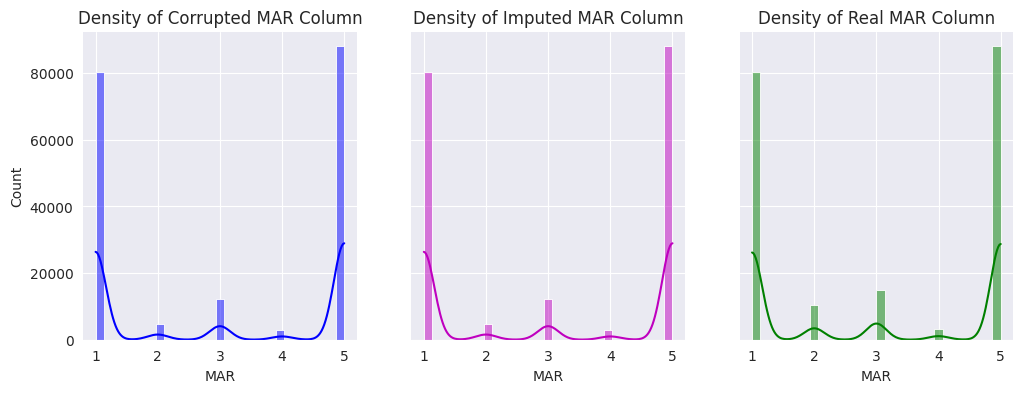





 ###############  Impute MAR column with predict-by-sklearn technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


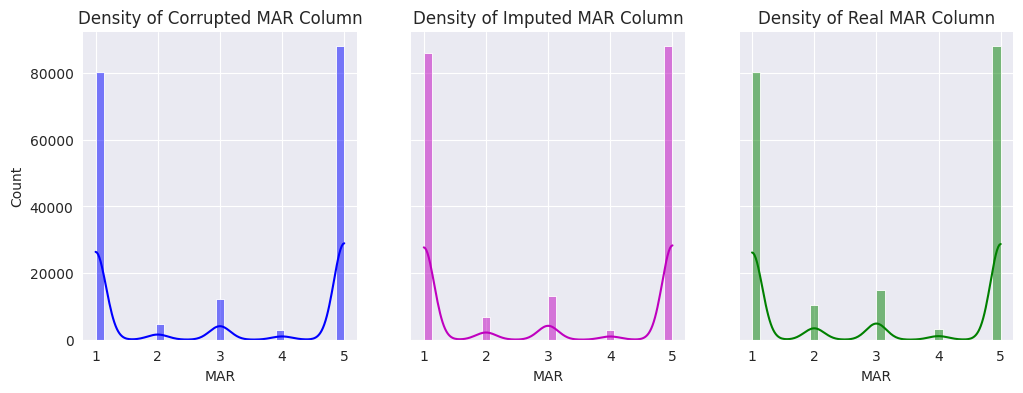





 ###############  Impute MAR column with impute-by-mode technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


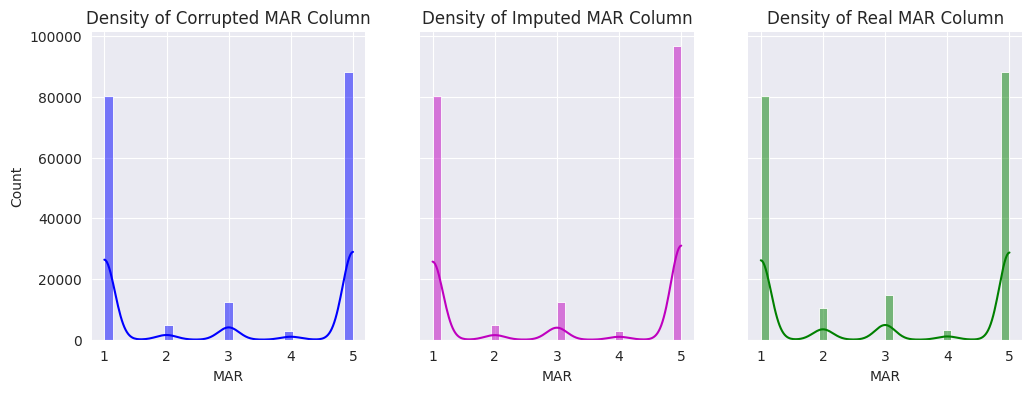





 ###############  Impute MAR column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


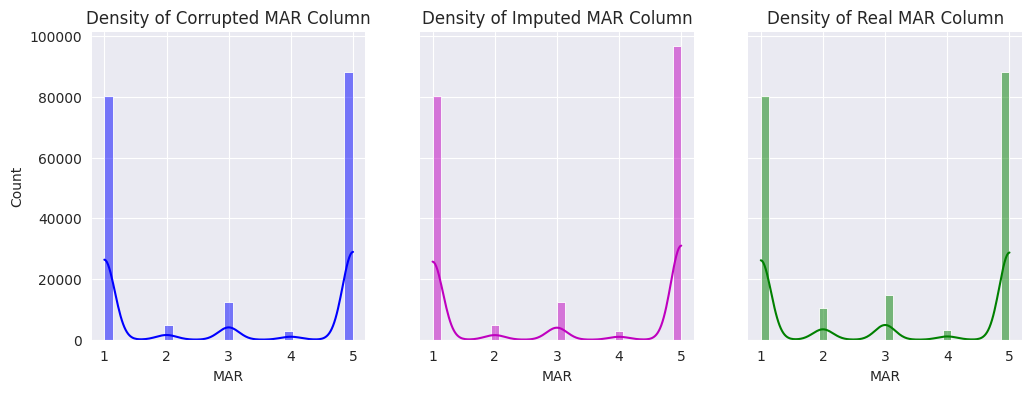





 ###############  Impute MAR column with impute-by-mode-conditional technique  ###############
Impute MAR with value 5.0, where SEX == 2
Impute MAR with value 5.0, where SEX == 1
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


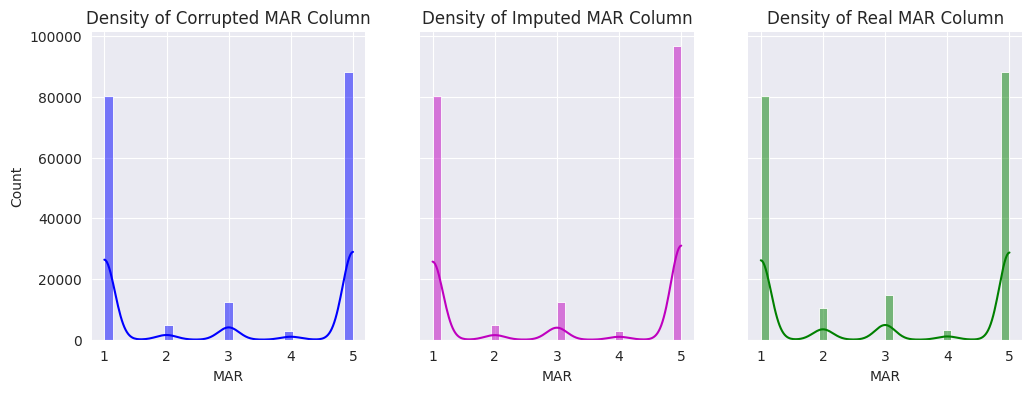

Impute MAR with value 1.0, where RAC1P == 1
Impute MAR with value 5.0, where RAC1P == 2
Impute MAR with value 5.0, where RAC1P == 8
Impute MAR with value 5.0, where RAC1P == 9
Impute MAR with value 5.0, where RAC1P == 3
Impute MAR with value 1.0, where RAC1P == 6
Impute MAR with value 5.0, where RAC1P == 5
Impute MAR with value 5.0, where RAC1P == 7
Impute MAR with value 1.0, where RAC1P == 4
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


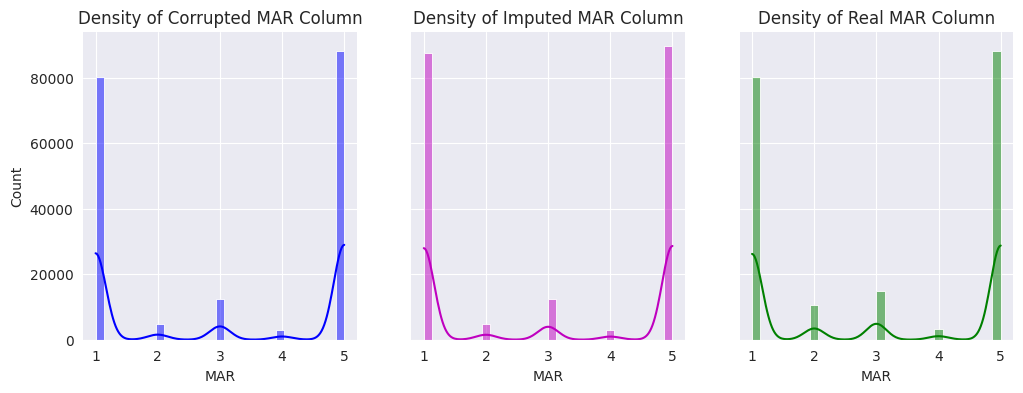

In [29]:
imputed_data_dict = impute_df_with_all_techniques(X_data, corrupted_data, TARGET_COLUMN, COLUMN_TYPE)